# Kinematic smearing

In [1]:
import sys

sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRG_MPI/thumair_jpsiks/pythonTools")
sys.path.append("/nfs/dust/belle2/user/kapitanl/Analysis/PRD_MPI/Lib_Xgboost/xgboost/python-package")
!{sys.executable} -m pip install iminuit==2.2.1

%env TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/bin/python3.6m -m pip install --upgrade pip' command.
env: TOERASEDIR=/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/filesForRemove


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pdf
import pandas as pd
import rootTools as tap
plt.rcParams["figure.figsize"] = (14,10)

Welcome to JupyROOT 6.20/04


In [3]:
import noteBookTools as nbt
totDicts = nbt.getDictForBDT()
listVars = [totDict['var'] for totDict in totDicts] + ['KFold', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr', 'MCDeltaT','DeltaT']
listFormulas = [totDict['form'] for totDict in totDicts] + ['__event__ % 2', 'TagVLBoost', 'TagVmcLBoost', 'TagVLBoostErr', 'MCDeltaT', 'DeltaT']

totDictKins = nbt.getDictForBToDPi("B0toPiDStoK4Pi")
listVarKins = [totDictKin['var'] for totDictKin in totDictKins] 
listFormulaKins = [totDictKin['form'] for totDictKin in totDictKins] 

In [4]:
tupleDir = "/nfs/dust/belle2/user/jkandra/MC13-04/B0toPiDStoK4Pi/"

In [5]:
Data = tap.getPandaFromFiles(fileNames=[tupleDir+"B0toPiDStoK4Pi.root"],
                               listVarFormulas=listFormulas + listFormulaKins,
                               listVarNames=listVars + listVarKins, 
                               treeName="B0ToDStmpip_DtoK3pi", cut="isSignal")


........... 


In [15]:
vData = Data["MCDeltaT"].to_numpy()

## Resolution function

bgc 86.12366327934411
{'mus': -0.06505674086271626, 'sigmas': 0.36533097568258693, 'fTMains': 0.20052232492692912, 'fTR': 0.40755852195088677, 'fTBigs': 0.6125374040532355, 'cLMs': 0.0972931800582807, 'cRMs': 0.0679911008158661, 'cLBs': 0.4886588562076765, 'cRBs': 0.4553106409499707, 'bigSigmaScale': 2.0362896562958253, 'bigSigmaFrac': 0.7138521642011941}
{'mus': 0.0, 'sigmas': 0.0001, 'fTMains': 0.0, 'fTR': 0.40755852195088677, 'fTBigs': 0.6125374040532355, 'cLMs': 0.0972931800582807, 'cRMs': 0.0679911008158661, 'cLBs': 0.4886588562076765, 'cRBs': 0.4553106409499707, 'bigSigmaScale': 2.0362896562958253, 'bigSigmaFrac': 0.0}
xH [-4.99857102 -4.99571306 -4.9928551  ...  4.9928551   4.99571306
  4.99857102]
C 647.8393826806466
# events 226679


(None,)

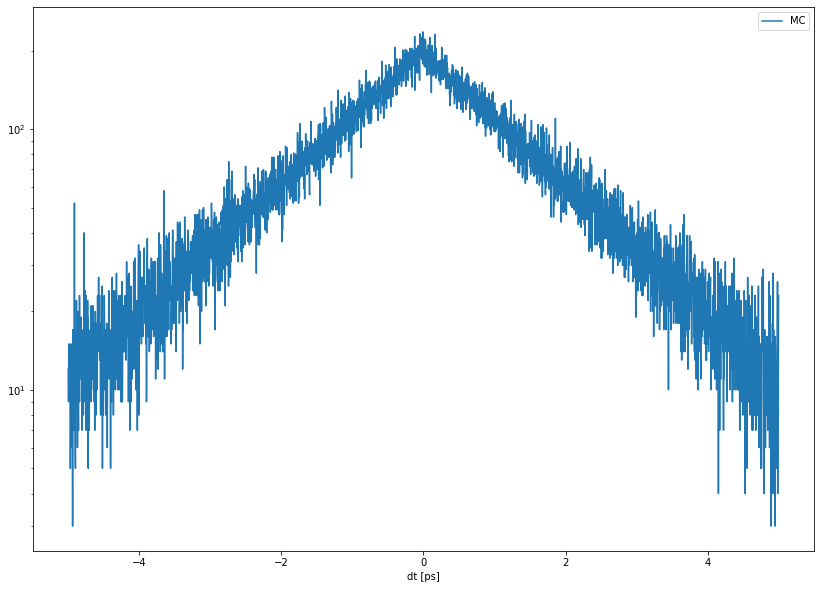

In [16]:
# Transform parameters from um to ps

beta = 276.11e-3
c = 299.792458 # um/ps
bgc = beta/(1 - beta**2)**0.5 * c
print('bgc', bgc)


'''pars = {
   'mus': -0.07029368571683735 / bgc,
   'sigmas': 0.3918262885418164/ bgc,
   'fTMains': 0.1402839955940452, 
   'fTR': 0.3601912814334793,
   'cLMs': 0.1036841394460027 * bgc,
   'cRMs': 0.06803381698743874 * bgc,
   'bigSigmaScale': 2.1767453589245225,
   'bigSigmaFrac': 0.6036344190332074,
   'fTBigs': 0.6268934047143494,
   'cLBs': 0.5720441320352365 * bgc,
   'cRBs': 0.48831611234179223 * bgc
}
'''
#parameters from mcDeltaT - DeltaT fit : already correct dimension
pars = {'mus': -0.06505674086271626, 'sigmas': 0.36533097568258693,
        'fTMains': 0.20052232492692912, 'fTR': 0.40755852195088677,
        'fTBigs': 0.6125374040532355, 'cLMs': 0.0972931800582807,
        'cRMs': 0.0679911008158661, 'cLBs': 0.4886588562076765,
        'cRBs': 0.4553106409499707, 'bigSigmaScale': 2.0362896562958253,
        'bigSigmaFrac': 0.7138521642011941}
print(pars)

# Dummy parameters for no resolution smearing
pars0 = pars.copy()
pars0["mus"] = 0.0
pars0["sigmas"] = 0.0001
pars0["fTMains"] = 0.
pars0["bigSigmaFrac"] = 0.
print(pars0)

xLim = 5
x = np.linspace(-xLim, xLim, 3500)

#MC histogram
hMC = np.histogram((vData), bins=(x))
xH = (hMC[1][1:] + hMC[1][:-1]) / 2
print('xH', xH)
xSize = (xH[1:] - xH[:-1]) / 2

#scaling factor for multiplying the normalized function 

C = 2*xSize[0]*np.sum(hMC[0]) 
print('C', C)
print('# events', np.sum(hMC[0]))


#y1 = np.vectorize(lambda t : pdf.resFun(t, pars))(xH)
y = np.vectorize(lambda t : pdf.resFun(t, pars))(x)
y0 = np.vectorize(lambda t : pdf.resFun(t, pars0))(x)


plt.plot(xH, hMC[0], label="MC")
#plt.plot(x,C*y )
#plt.plot(xH, C*y1)
#plt.plot(hMC[1], 32E10*y0, label = 'pars0')

plt.legend()
plt.yscale("log")
plt.xlabel("dt [ps]")


dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
plt.savefig(dirName+"MCB0toPiDStoK4Pi_pdfTest.png", bbox_inches='tight'), 

### B Decays

Plot of the B-decay time for various thetaCMS, looks like huge differences

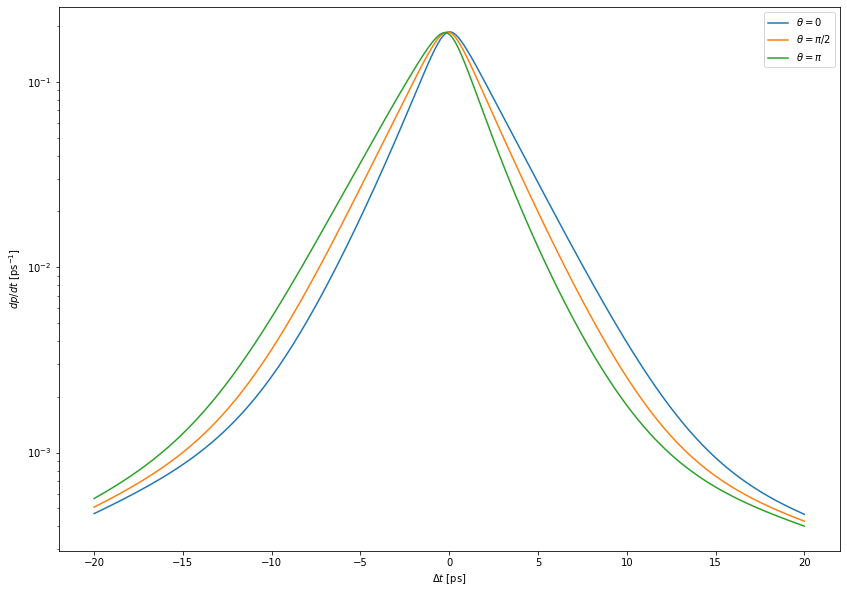

In [17]:
xLim = 5
x    = np.linspace(-4*xLim, 4*xLim, 500 )
tau = 1.520
y0   = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=0))(x)
yOrt = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi/2))(x)
y1   = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi))(x)
#yOrtR= np.vectorize(lambda t : pdf.funDecayTheta(t, pars0, np.pi/2))(x)

plt.plot(x, y0,   label=r'$\theta=0$')
plt.plot(x, yOrt, label=r'$\theta=\pi/2$')
plt.plot(x, y1,   label=r'$\theta=\pi$')
plt.ylabel('$dp/dt$ [ps$^{-1}$]')
plt.xlabel(r'$\Delta t$ [ps]')
plt.legend()
plt.yscale("log")

Plot the comparizon of the theta-integrated scenario and the case with no kin-smearing effect

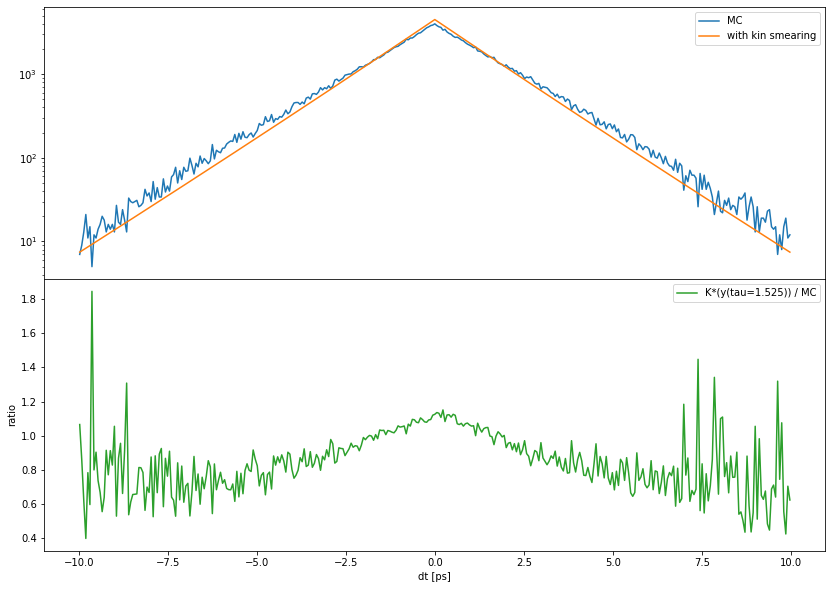

In [33]:
xLim = 10
tau = 1.525
x    = np.linspace(-xLim, xLim, 350 )

hMC = np.histogram((vData), bins=x)
#print('hMC[1]',hMC[1])
#print('hMC[0]',hMC[0])
xH = (hMC[1][1:] + hMC[1][:-1]) / 2
#print('xH',xH)
#print('x',x)
xSize = (x[1:] - x[:-1]) / 2

yOrt  = np.vectorize(lambda t : pdf.funDecayTheta(t, pars0, tau=1.725, theta=np.pi/2))(xH)
yTest = np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau=1.725, theta=np.pi/2))(xH)
ySm   = np.vectorize(lambda t : pdf.funDecay(t, pars0, tau=1.525))(xH)
yTest2 =np.vectorize(lambda t : pdf.funDecayTheta(t, pars, tau = 1.4,theta=np.pi/2))(xH)


plt.plot()
plt.subplots_adjust(hspace=0)
ax = plt.subplot(211)

C = 2*xSize[0]*np.sum(hMC[0]) 
plt.plot(xH, hMC[0], label="MC")
#plt.plot(xH, C*yOrt, label='without kin. smearing, tau = 1.725')
plt.plot(xH, C*ySm, label='with kin smearing')
#plt.plot(xH, C*yTest, label='test curve')
#plt.plot(xH, C*yTest2, label='test curve2')
#plt.plot(x, 1500*yTest, label='test curve') x = 1
  
        
                
plt.yscale("log")
#plt.xlabel("dt [ps]")
plt.legend()
plt.subplot(212, sharex=ax)


#plt.plot(x, ySm / yOrt, color='C1')
#plt.plot(x, yTest / yOrt, color='C2')


#plt.plot(xH, C*yOrt/hMC[0], color = 'C1', label = 'K*(y(tau=1.725,theta = pi/2)) / MC') #used to be 1.6
plt.plot(xH, C*ySm / hMC[0], color = 'C2', label = 'K*(y(tau=1.525)) / MC')
#plt.plot(xH, C*yTest / hMC[0], color = 'C3', label = 'K*(y(tau=1.525,theta = pi/2)) / MC')
#plt.plot(xH, C*yTest2 / hMC[0], color = 'C4', label = 'K*(y(tau=1.4,theta = pi/2)) / MC')

plt.xlabel("dt [ps]")
plt.legend()
plt.ylabel("ratio")

dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
plt.savefig(dirName+"MCB0toPiDStoK4Pi_BDecays.png", bbox_inches='tight')

# Fit

In [19]:
# Resolution function convoluted with (complex) exp
def FunT(x, pars2, c):
    
    #mus = -0.06505674086271626
    #sigmas = 0.36533097568258693
    #fTMains = 0.20052232492692912
    #bigSigmaFrac = 0.7138521642011941
    fTR = 0.40755852195088677
    fTBigs = 0.6125374040532355
    cLMs = 0.0972931800582807
    cRMs = 0.0679911008158661
    cLBs = 0.4886588562076765
    cRBs = 0.4553106409499707
    bigSigmaScale = 2.0362896562958253
    sigmas = 0.0001
    fTMains = 0.
    bigSigmaFrac = 0.
    mus = 0.
    
    '''mus = -0.033424851411719914
    sigmas = 0.4068974310832354
    fTMains = 0.4793633749213265
    fTR = 0.08221071527299662
    fTBigs =  0.8869272217841198
    cLMs = 0.3915765366726773
    cRMs = 0.06700089929198765
    cLBs = 0.00016925096165154994
    cRBs = 0.4331244662578779
    bigSigmaScale = 2.288240916723551
    bigSigmaFrac = 0.7874582669546637'''
   
 
  
   # mus = -0.04770939314447986
    
    #fTR = pars2['fTR']
    #fTBigs = pars2['fTBigs']
    
    #cLMs = pars2['cLMs']
    #cRMs = pars2['cRMs']
    #cLBs = pars2['cLBs']
    #cRBs = pars2['cRBs']
    #bigSigmaScale = pars2['bigSigmaScale']
   # cLMs = 0.48539346895738267
   # cRMs = 0.45040657487907737
   # cLBs = 0.09717889549177022
   # cRBs = 0.06633866206047234
   # bigSigmaScale = 0
    
    
    ret = 0
    
    # small gauss
    ret += (1-bigSigmaFrac) * (1-fTMains) * pdf.GE_conv([mus, sigmas], [0,c], x)
    ret += (1-bigSigmaFrac) * fTMains*(1.-fTR)* pdf.GEE_conv([mus,sigmas], [mus, -cLMs], [0, c], x) 
    ret += (1-bigSigmaFrac) * fTMains*(fTR)* pdf.GEE_conv([mus,sigmas], [mus, +cRMs], [0, c], x)
    # big gauss
    ret += bigSigmaFrac * (1-fTBigs) * pdf.GE_conv([mus, bigSigmaScale*sigmas], [0, c], x)
    ret += bigSigmaFrac * fTBigs*(1.-fTR)* pdf.GEE_conv([mus,bigSigmaScale*sigmas], [mus, -cLBs], [0, c], x)
    ret += bigSigmaFrac * fTBigs*(fTR)* pdf.GEE_conv([mus,bigSigmaScale*sigmas], [mus, +cRBs], [0, c], x)
    
    return ret

def fun(x, pars2, theta=np.pi/2, K=0.22359):
    #funDecayTheta(x, pars, tau=1.520, theta=np.pi/2, K=0.22359):
    #K = 0.22534  # currently hard-coded
    #K = 0.22359  # using nominal BoostVector and Y4S mass
    #tau = 1.520  # ps
    
    tau = pars2['tau']
    cp = +1./tau * 1./(1 + K*np.cos(theta))
    cm = -1./tau * 1./(1 - K*np.cos(theta))

    r = 1./(2*tau) * (1./abs(cp)*FunT(x, pars2, cp) + 1./abs(cm)*FunT(x, pars2, cm))
    return r

In [21]:
import chebFitter as chf
xLim = 15
ch = chf.chebFitter(516+ 1, -xLim, xLim, vData, fun)
#pars = {"mus" : 0, "sigmas" : 30,  "fTMains" : 0.9, "fTR" : 0.5, "fTBigs":0.1, "cLMs" : 0.1, "cRMs" : 0.1, "cLBs":0.1, "cRBs":0.1, "bigSigmaScale":5, "bigSigmaFrac":0.1 }

#fitting only tau
'''pars2 = {'mus': 0, 
         'cLMs': 0.0972931800582807,'cRMs': 0.0679911008158661, 
         'cLBs': 0.4886588562076765, 'cRBs': 0.4553106409499707, 
         'fTR': 0.40755852195088677, 'fTBigs': 0.6125374040532355,
        'bigSigmaScale': 2.0362896562958253,        
        'tau' : 1.525}'''
pars2 = {'tau':1.525}


'''pars2 = {'mus': -0.06505674086271626, 'sigmas': 0.36533097568258693,
        'fTMains': 0.20052232492692912,, 'cLMs': 0.0972931800582807,
        'cRMs': 0.0679911008158661, 'cLBs': 0.4886588562076765,
        'cRBs': 0.4553106409499707, 'bigSigmaScale': 2.0362896562958253,
        'bigSigmaFrac': 0.7138521642011941, 'tau' : 1.2311083016861821}'''

#pars2 = res

#fitting all parameters

'''pars2 = {'mus': -0.09950552127341979, 'sigmas': 0.3773818173506863, 
'fTMains': 0.21099606421707875, 'fTR': 0.435630465256587,
'fTBigs': 0.6235612087082469, 'cLMs': 0.03422653215506476, 
'cRMs': 0.062059574025524554, 'cLBs': 0.5031689274082135, 
'cRBs': 0.5431854360535253, 'bigSigmaScale': 2.531814591816673, 
'bigSigmaFrac': 0.6447696147458938, 'tau': 1.269755316704414}'''

'''std = 0.01037958862391452
0.04413005444740216
0.028735047376922264
0.012584256289613014
0.03519298562841825
0.0072053912432186035
0.017005221008815807
0.014651416083295283
0.02132240324458665
0.30526004334467904
0.04106998632380746
0.02827249086022191'''

Limits = {'mus': (-10, 10),
        'sigmas': (10, 40),
        'fTMains': (0, 1),
        'fTR': (0, 1),
        'cLMs': (1e-5, 0.1),
        'cRMs': (1e-5, 0.1),
         "bigSigmaScale": (3, 40),
        'bigSigmaFrac' : (0,1),
        'fTBigs' : (0,1),
        'cLBs' : (1e-5, 0.05),
        'cRBs' : (1e-5, 0.05),
        'tau' : (1.0 , 2.0)}


res =  ch.fitData(pars2)
print(res)

Loading data grid
Done


/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/chebFitter/python/chebFitter.py:122: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


0.0035507281957719936
{'tau': 1.7275564080547963}


In [22]:
def plotHist(d, bins, chFit, res):
    vals, bins = np.histogram(d, bins)
    xCnt  = (bins[1:] + bins[:-1]) / 2
    xSize = (bins[1:] - bins[:-1]) / 2
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[16,3]}, figsize=(12,8))
    axs[0].set_yscale('log')
    axs[0].errorbar(xCnt, vals, xerr=xSize, yerr=np.sqrt(vals), ls='none', fmt="o")
    
    N = np.dot(vals, 2*xSize) 
    x = np.linspace(bins[0], bins[-1], 1090)
    y = N * chFit.funFast(x, res)
    axs[0].plot(x, y, label='B0toJPsiKStoEE - tau = '+str(pars2['tau']) + ' ps')
    axs[0].legend(loc='lower center', shadow=True, fontsize='x-large')
    # plotRatio
    yRat= N * chFit.funFast(xCnt, res) 
    axs[1].errorbar(xCnt, vals/ yRat, xerr=xSize, yerr=np.sqrt(vals)/yRat, ls='none', fmt="o")

    dirName = "/nfs/dust/belle2/user/kapitanl/Analysis/Thesis/Hist/"
    fig.savefig(dirName+"MCB0toPiDStoK4Pi_pdf_Tau.png", bbox_inches='tight')


In [ ]:
plotHist(vData, np.linspace(-xLim, xLim, 200), ch, res)

## B Oscilations

Let's first check the behaviour of the functions.

Notice that the real part is cosine and imaginery sine

In [ ]:
#Checking the value at dt = 0 (should be equal) ---> isnt
print(pdf.funDecay(0, pars0), pdf.funOsc(0, pars0).real)

import scipy.integrate

#Checking the integrals

dm = 0.510
C = 1 + tau**2 * dm**2
print(C)

print(scipy.integrate.quad(lambda t: C*pdf.funOscTheta(t, pars0, tau=tau, dm=dm, theta=np.pi/2).real, -200, 200))
print(scipy.integrate.quad(lambda t: C*pdf.funOscTheta(t, pars, tau=tau, dm=dm, theta=np.pi/2).real, -20, 20))
print(scipy.integrate.quad(lambda t: C*pdf.funOsc(t, pars0, tau=tau, dm=dm).real, -1, 1))
print(scipy.integrate.quad(lambda t: C*pdf.funOsc(t, pars,  tau=tau, dm=dm).real, -1, 1))

Composing the full function

In [ ]:
# exp(-|dt|/tau) * (1 + cos dm t)
def fullPDFnoKin(t, pars):
    C = 1 + 1./(1+tau**2 * dm**2)
    return 1/C * (pdf.funDecayTheta(t, pars, tau=tau, theta=np.pi/2) + pdf.funOscTheta(t, pars, tau=tau, dm=dm, theta=np.pi/2).real)

def fullPDF(t, pars):
    C = 1 + 1./(1+tau**2 * dm**2)
    return 1/C * (pdf.funDecay(t, pars, tau=tau) + pdf.funOscTheta(t, pars, tau=tau, dm=dm).real)


yOrt0 = np.vectorize(lambda t : fullPDFnoKin(t, pars0) )(x)
yOrt  = np.vectorize(lambda t : fullPDFnoKin(t, pars) )(x)
ySm   = np.vectorize(lambda t : fullPDF(t, pars) )(x)
plt.plot(x, yOrt0, label='Original true-dist.')
plt.plot(x, yOrt, label='with resFun')
plt.plot(x, ySm, label='with resFun+kin. sm.')
plt.yscale("log")
plt.xlabel("dt [ps]")
plt.legend()
plt.savefig('mixing.pdf')
plt.show()


# Impact of the kinematic term

plt.plot(x, ySm/yOrt, color='C2')
plt.xlabel("dt [ps]")
plt.ylabel("ratio of kinSmearing impact")
plt.ylim(0.9, 1.4)

# Check normalization
print('Normalizations:', np.sum(yOrt0)*(x[1]-x[0]), np.sum(yOrt)*(x[1]-x[0]), np.sum(ySm)*(x[1]-x[0]))


Plot with approximate cumulative statistic, assuming 1 bilion B-B pairs and BR=1e-4

In [ ]:
plt.plot(x, np.cumsum(ySm)/ np.cumsum(ySm)[-1] * 1e9 * 1e-4 )
plt.yscale("log")
plt.xlabel("dt [ps]")
plt.ylabel("Cumulative nunber of events")